In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

Bu adımda yapılanlar:
UC Sales > 0 değeri olanlar alındı. Hiç bir sütunda 0'dan küçük değer bulunmamakta. 
Frequency = 2 olanlar ve T = 0 olanlar hesaplamaya katılmadı.
Analiz yapılan outlet sayısı 1667'den 1596'a düştü.

In [2]:
df = pd.read_excel(r'C:\Users\tgolgeli\OneDrive - Coca-Cola Icecek A.S\CCI Desktop\DenizliRFM.xlsx', index_col = 0)
den = df[df["Calendar day"] >= pd.to_datetime('2022-06-01')]
den_py = pd.read_excel(r'C:\Users\tgolgeli\OneDrive - Coca-Cola Icecek A.S\CCI Desktop\PY_DenizliRFM.xlsx', index_col = 0)

In [3]:
outlet23 = den["Outlet Number"].unique()
data = den_py[den_py["Outlet Number"].isin(outlet23)]
data.shape

(39658, 10)

In [4]:
data.head()

,Distributor,Preseller,Ordering Tool,Outlet Number,Outlet Name,Invoice Number,Calendar year / week,Calendar Year/Month,Calendar day,UC Sales
Distributor Location,,,,,,,,,,
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92114044658,46.2021,11.2021,2021-11-20,25.398
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92115119948,48.2021,12.2021,2021-12-04,26.013
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92115709103,49.2021,12.2021,2021-12-11,50.415
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92116264144,50.2021,12.2021,2021-12-18,12.384
92,DEN-MERKEZ-CELIKKOL,9201 : Aykut Gokturk,CCI Next,7031655,GUNES MARKET-RAFET KAPIKIRAN,92117373035,1.2022,1.2022,2022-01-03,23.223


In [5]:
#Returned goods were eliminated from the data
data = data[data["UC Sales"] >= 0]
data.shape

(39623, 10)

In [6]:
data["Calendar day"].min(), data["Calendar day"].max()

(Timestamp('2021-06-01 00:00:00'), Timestamp('2022-05-31 00:00:00'))

In [7]:
#last 1 year was taken as interval from 01.06.2022 - 31.05.2023
#recency: today(): 01.6.2023 - CCINext_lastorderdate
most_recent = pd.to_datetime("2022-06-01") - data.groupby('Outlet Number')['Calendar day'].max()
recency = most_recent.reset_index()
recency = recency.rename(columns= {'Calendar day': 'R'})
recency

,Outlet Number,R
0,7030104,1 days
1,7030106,1 days
2,7030252,4 days
3,7030259,8 days
4,7030323,12 days
...,...,...
1662,10778124,23 days
1663,10778684,5 days
1664,10778875,6 days
1665,10780705,4 days


In [8]:
FM = data.groupby('Outlet Number').agg({'Invoice Number': 'count', 'UC Sales':'sum'})
FM = FM.rename(columns={'Invoice Number': 'F', 'UC Sales': 'M'})

In [9]:
RFM = recency.merge(FM, on = "Outlet Number")
RFM

,Outlet Number,R,F,M
0,7030104,1 days,22,293.254
1,7030106,1 days,41,12393.778
2,7030252,4 days,31,2109.309
3,7030259,8 days,18,222.480
4,7030323,12 days,25,291.102
...,...,...,...,...
1662,10778124,23 days,1,25.799
1663,10778684,5 days,2,58.187
1664,10778875,6 days,1,11.896
1665,10780705,4 days,2,5.915


In [10]:
#for the outlets ordered on the same day, UC volume of those orders were aggregated.
#intervals between orders and their mean values were calculated.
T = data.groupby(["Outlet Number", "Calendar day"], as_index = False)["UC Sales"].sum()
T["shift"] = T.groupby("Outlet Number")["Calendar day"].shift(1)
T["orderdiff"] = T["Calendar day"] - T["shift"]
T = T.dropna(subset = ["orderdiff"])
#time intervals were calculated and NA values were eliminated.
T

,Outlet Number,Calendar day,UC Sales,shift,orderdiff
1,7030104,2021-10-13,14.794,2021-10-12,1 days
2,7030104,2021-11-02,1.584,2021-10-13,20 days
3,7030104,2021-11-09,6.340,2021-11-02,7 days
4,7030104,2021-11-23,14.637,2021-11-09,14 days
5,7030104,2021-12-07,5.600,2021-11-23,14 days
...,...,...,...,...,...
36184,10776992,2022-05-31,6.318,2022-05-24,7 days
36186,10777723,2022-05-12,68.692,2022-05-07,5 days
36187,10777723,2022-05-26,4.226,2022-05-12,14 days
36192,10778684,2022-05-27,47.116,2022-05-20,7 days


In [11]:
Tmean = T.groupby("Outlet Number")["orderdiff"].sum() / T.groupby("Outlet Number")["orderdiff"].count()
Tmean = Tmean.dt.days
Tmean

Outlet Number
7030104     12
7030106      7
7030252     10
7030259     12
7030323     10
            ..
10776537     7
10776992    10
10777723     9
10778684     7
10780705     7
Name: orderdiff, Length: 1618, dtype: int64

In [12]:
RFMT = RFM.merge(Tmean, left_on = "Outlet Number", right_on=Tmean.index, how = "left")
RFMT["R"] = RFMT["R"].dt.days
RFMT = RFMT.rename(columns = {"orderdiff": "T"})
RFMT["T"].fillna(0, inplace = True)
RFMT

,Outlet Number,R,F,M,T
0,7030104,1,22,293.254,12.0
1,7030106,1,41,12393.778,7.0
2,7030252,4,31,2109.309,10.0
3,7030259,8,18,222.480,12.0
4,7030323,12,25,291.102,10.0
...,...,...,...,...,...
1662,10778124,23,1,25.799,0.0
1663,10778684,5,2,58.187,7.0
1664,10778875,6,1,11.896,0.0
1665,10780705,4,2,5.915,7.0


In [13]:
# 1 veya 2 alım alanlar elendi. 1 alım yapanların T değeri 0, 2 alımda ise T için ortalama bir değer çıkmıyor.

RFMT[(RFMT["F"] == 2) | (RFMT["T"] == 0)]

,Outlet Number,R,F,M,T
12,7030805,266,2,48.608,7.0
16,7031079,263,1,54.530,0.0
34,7031964,189,1,1.585,0.0
55,7034343,105,1,28.699,0.0
83,7035451,247,2,32.168,7.0
...,...,...,...,...,...
1662,10778124,23,1,25.799,0.0
1663,10778684,5,2,58.187,7.0
1664,10778875,6,1,11.896,0.0
1665,10780705,4,2,5.915,7.0


In [14]:
RFMT = RFMT[~(RFMT["F"] == 2) & ~(RFMT["T"] == 0)]

## After the Preprocessing Step

In [15]:
RFMT.describe()

,Outlet Number,R,F,M,T
count,1.596000e+03,1596.000000,1596.000000,1596.000000,1596.000000
mean,9.158335e+06,15.639098,24.766291,684.354411,13.493108
std,1.049463e+06,28.617860,14.595482,816.926030,10.572423
min,7.030104e+06,1.000000,3.000000,4.225000,3.000000
25%,9.119078e+06,4.000000,14.000000,200.478750,8.000000
50%,9.467772e+06,7.000000,23.000000,451.535500,11.000000
75%,9.627733e+06,18.000000,33.000000,900.953750,15.000000
max,1.077772e+07,272.000000,107.000000,12393.778000,160.000000


<AxesSubplot:xlabel='T'>

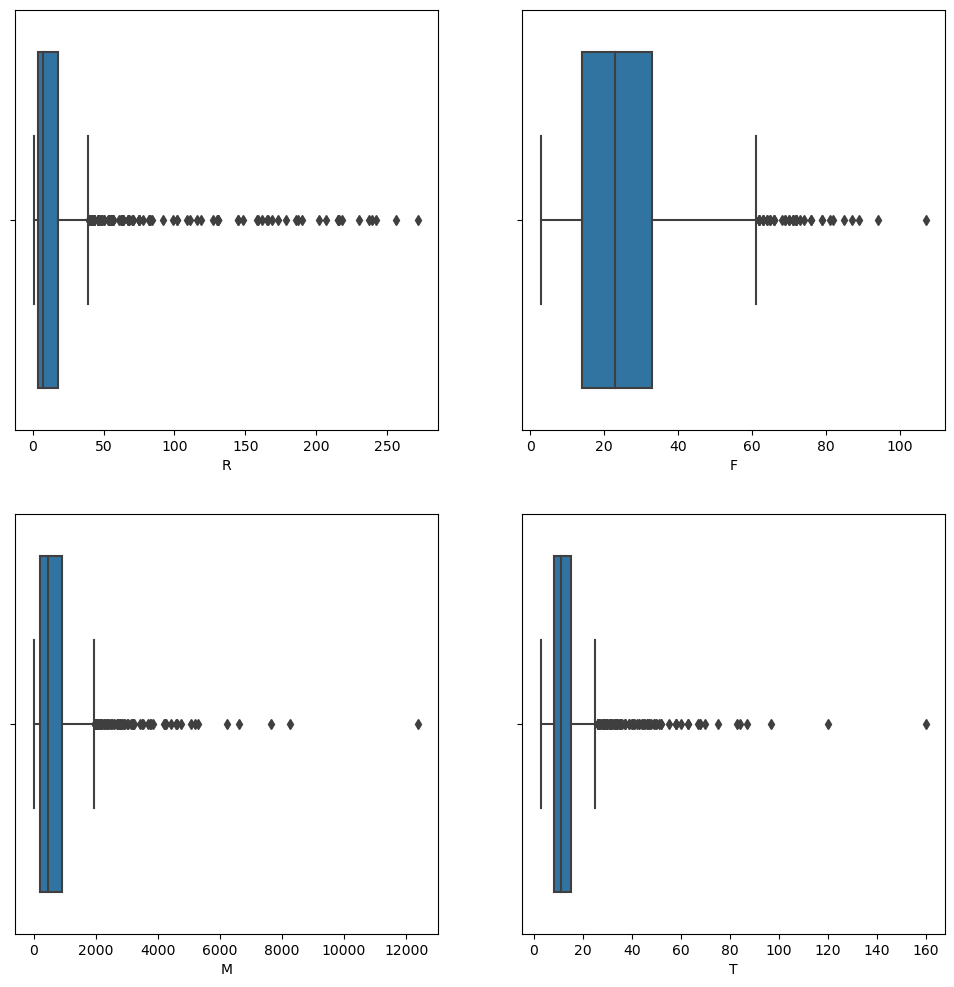

In [16]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
sns.boxplot(data = RFMT, x = "R", ax = ax[0,0])
sns.boxplot(data = RFMT, x = "F", ax = ax[0,1])
sns.boxplot(data = RFMT, x = "M", ax = ax[1,0])
sns.boxplot(data = RFMT, x = "T", ax = ax[1,1])

<AxesSubplot:xlabel='T', ylabel='Count'>

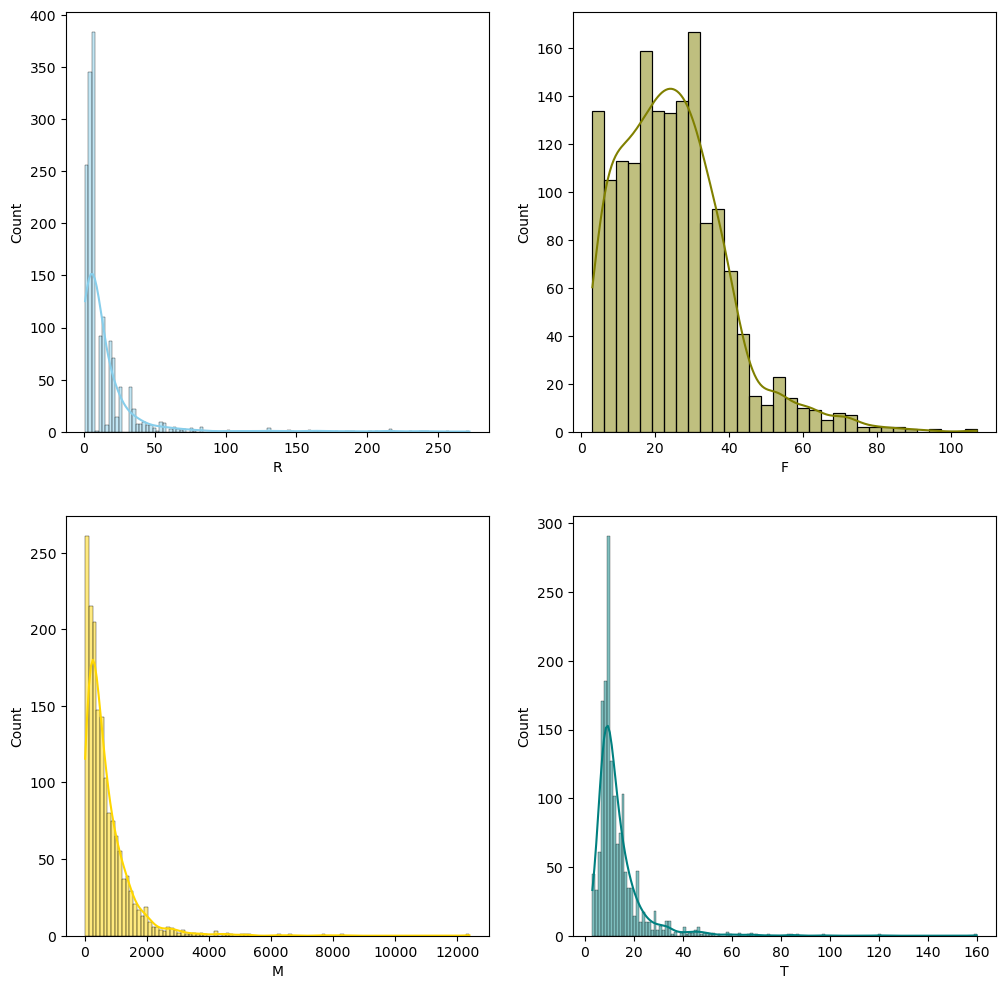

In [17]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
sns.histplot(data = RFMT, x = "R", kde = True, color = "skyblue", ax =ax[0,0])
sns.histplot(data = RFMT, x = "F", kde = True, color = "olive", ax =ax[0,1])
sns.histplot(data = RFMT, x = "M", kde = True, color ="gold", ax =ax[1,0])
sns.histplot(data = RFMT, x = "T", kde = True, color = "teal", ax =ax[1,1])

## Outlier Analysis

Bu adımda BoxPlot'da whisher'ların dışında kalan Outlier noktalarını elemek için ilk önce whisher'ın upper limit'i hesaplandı.
Sonrasında her bir kategorideki üst değerler için bir sütun yaratılarak etiketleme yapıldı. Toplamda 4 tane artı sütun yaratıldı. Recency, Frequency, Monetary, ve Time Interval için birer tane. Bu etiketlemede yer almayan değerler için de artı bir sütun yaratılarak Outlier olmayan değerler için bir etiketleme yapıldı. 2160 değerden 648 tanesi upper limit üstündeki outlet sayısı. 1512 tane outlet ise normal sınırlar içerisinde.

In [18]:
pd.DataFrame(RFMT.iloc[:, 1:]).quantile([0.25,0.75])

,R,F,M,T
0.25,4.0,14.0,200.47875,8.0
0.75,18.0,33.0,900.95375,15.0


In [19]:
q1 = pd.DataFrame(RFMT.iloc[:,1:]).quantile(0.25)
q3 = pd.DataFrame(RFMT.iloc[:,1:]).quantile(0.75)
iqr = q3 - q1 #Interquartile range
#fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)
fence_high.round(1)

R      39.0
F      61.5
M    1951.7
T      25.5
dtype: float64

In [20]:
upperR = fence_high[0]
upperF = fence_high[1]
upperM = fence_high[2]
upperT = fence_high[3]
print(upperR, upperF, upperM, upperT)

39.0 61.5 1951.6662500000002 25.5


### Outlier Labeling

In [21]:
RFMT[RFMT["R"] > upperR]

,Outlet Number,R,F,M,T
28,7031622,46,12,169.752,19.0
36,7032296,46,15,1285.563,20.0
43,7033340,48,18,498.591,13.0
50,7033936,49,13,116.144,16.0
51,7034054,48,3,217.156,55.0
...,...,...,...,...,...
1552,10755420,55,5,86.425,7.0
1555,10756680,62,7,191.754,9.0
1574,10759855,43,5,85.751,15.0
1582,10761965,57,6,60.472,7.0


In [22]:
RFMT[RFMT["R"] > upperR].shape, RFMT[RFMT["F"] > upperF].shape, RFMT[RFMT["M"] > upperM].shape, RFMT[RFMT["T"] > upperT].shape

((115, 5), (40, 5), (86, 5), (122, 5))

In [23]:
RFMT.shape

(1596, 5)

In [24]:
RFMT.loc[:,"R"] > upperR

0       False
1       False
2       False
3       False
4       False
        ...  
1651    False
1653    False
1656    False
1658    False
1659    False
Name: R, Length: 1596, dtype: bool

In [25]:
RFMT["outR"] = np.where(RFMT["R"] > upperR, 'low recency', '0')
RFMT["outF"] = np.where(RFMT["F"] > upperF, 'freq buyers', '0')
RFMT["outM"] = np.where(RFMT["M"] > upperM, 'high spend', '0')
RFMT["outT"] = np.where(RFMT["T"] > upperT, 'occasional visit', '0')

C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_16740\172204200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFMT["outR"] = np.where(RFMT["R"] > upperR, 'low recency', '0')
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_16740\172204200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFMT["outF"] = np.where(RFMT["F"] > upperF, 'freq buyers', '0')
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_16740\172204200.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [26]:
RFMT

,Outlet Number,R,F,M,T,outR,outF,outM,outT
0,7030104,1,22,293.254,12.0,0,0,0,0
1,7030106,1,41,12393.778,7.0,0,0,high spend,0
2,7030252,4,31,2109.309,10.0,0,0,high spend,0
3,7030259,8,18,222.480,12.0,0,0,0,0
4,7030323,12,25,291.102,10.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1651,10774264,1,3,165.914,11.0,0,0,0,0
1653,10775542,21,3,50.921,11.0,0,0,0,0
1656,10776537,6,5,129.102,7.0,0,0,0,0
1658,10776992,1,3,22.041,10.0,0,0,0,0


In [27]:
RFMT["outR"].unique()

array(['0', 'low recency'], dtype=object)

In [28]:
RFMT["Outlier"] = np.where((RFMT["outR"] == '0') & (RFMT["outF"] == '0') & (RFMT["outM"] == '0') & (RFMT["outT"] == '0'), "NonOutliers", "Outliers")

C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_16740\2362627496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFMT["Outlier"] = np.where((RFMT["outR"] == '0') & (RFMT["outF"] == '0') & (RFMT["outM"] == '0') & (RFMT["outT"] == '0'), "NonOutliers", "Outliers")


In [29]:
NonOutliers = RFMT[RFMT["Outlier"] == "NonOutliers"]
NonOutliers

#1667 - 1596 tane değer outlier olduğu için elendi, 671 tane değer elendi.

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers
5,7030331,5,11,1189.121,20.0,0,0,0,0,NonOutliers
6,7030428,6,42,326.173,6.0,0,0,0,0,NonOutliers
...,...,...,...,...,...,...,...,...,...,...
1651,10774264,1,3,165.914,11.0,0,0,0,0,NonOutliers
1653,10775542,21,3,50.921,11.0,0,0,0,0,NonOutliers
1656,10776537,6,5,129.102,7.0,0,0,0,0,NonOutliers
1658,10776992,1,3,22.041,10.0,0,0,0,0,NonOutliers


## After Elimination

<AxesSubplot:xlabel='T'>

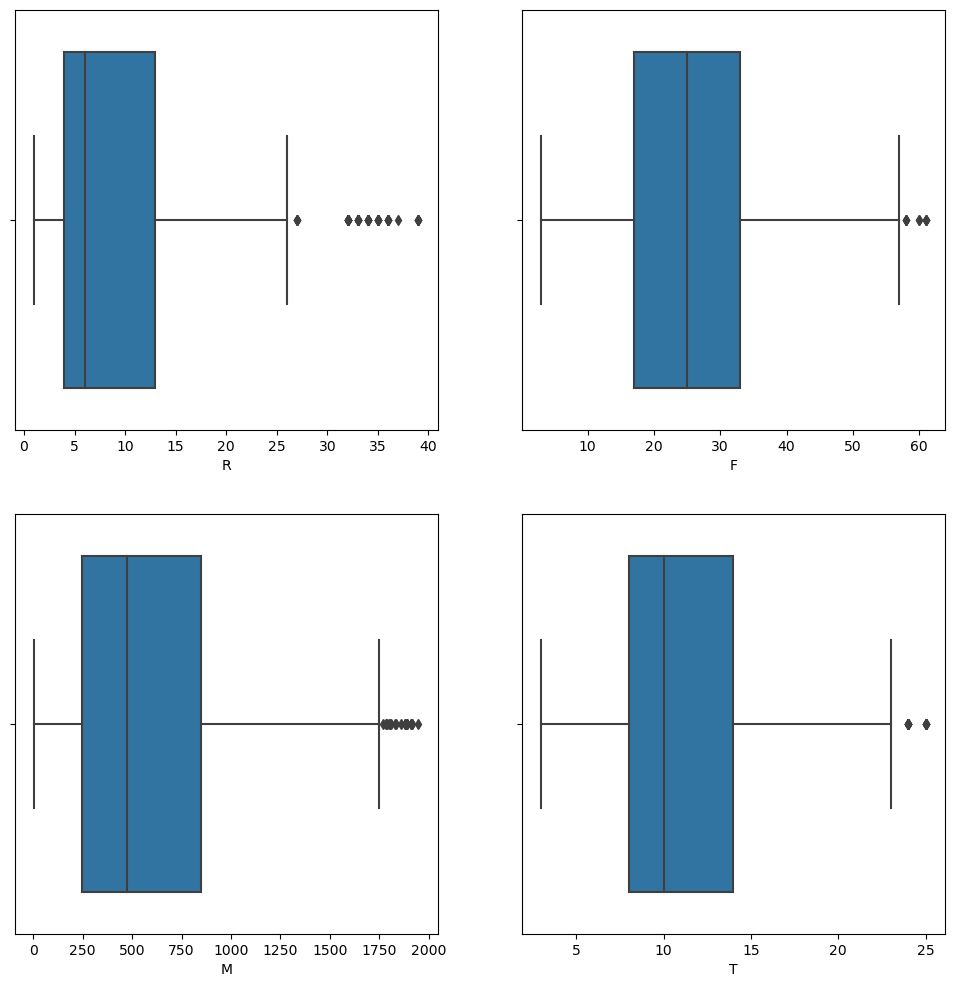

In [30]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
sns.boxplot(data = NonOutliers, x = "R", ax = ax[0,0])
sns.boxplot(data = NonOutliers, x = "F", ax = ax[0,1])
sns.boxplot(data = NonOutliers, x = "M", ax = ax[1,0])
sns.boxplot(data = NonOutliers, x = "T", ax = ax[1,1])

<AxesSubplot:xlabel='T', ylabel='Count'>

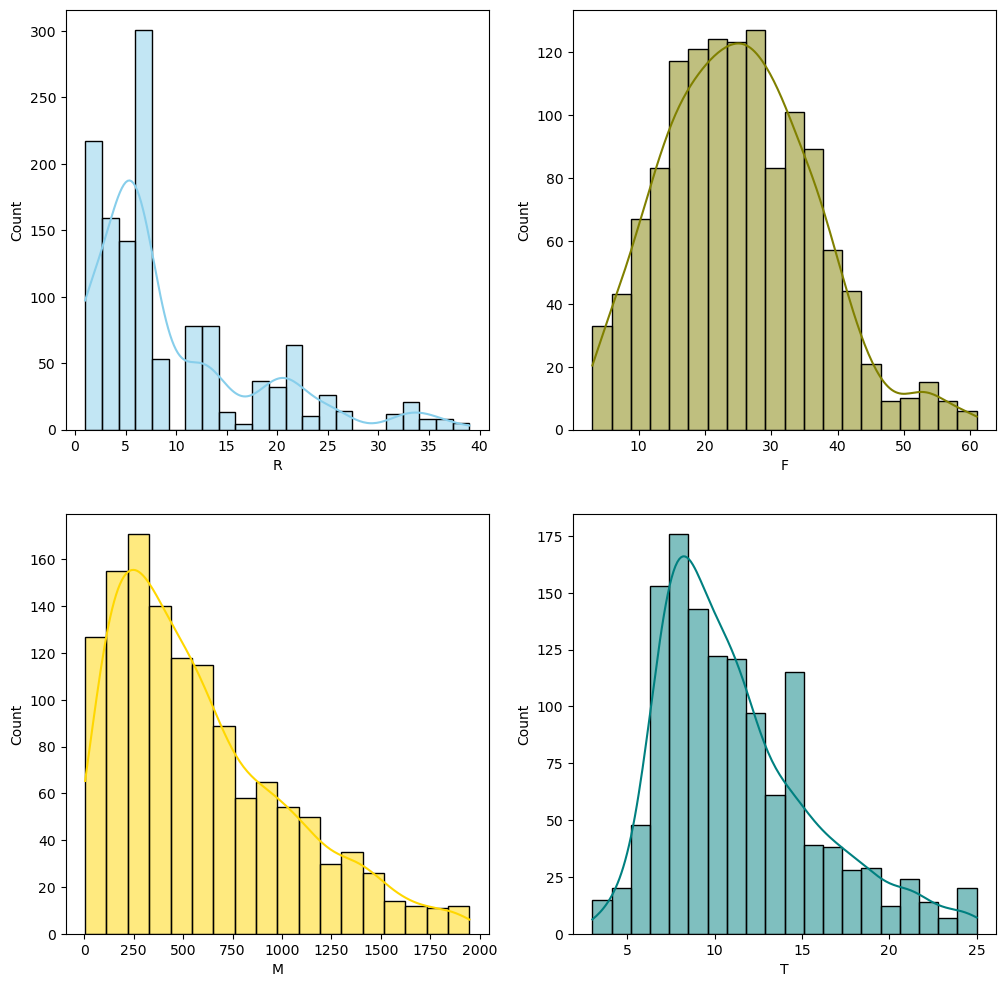

In [31]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
sns.histplot(data = NonOutliers, x = "R", kde = True, color = "skyblue", ax =ax[0,0])
sns.histplot(data = NonOutliers, x = "F", kde = True, color = "olive", ax =ax[0,1])
sns.histplot(data = NonOutliers, x = "M", kde = True, color ="gold", ax =ax[1,0])
sns.histplot(data = NonOutliers, x = "T", kde = True, color = "teal", ax =ax[1,1])

## RFM Indexes

METHOD 1: Belli bir kritere göre değerler kategorize edilir. Bu kategori sayısı 2 ile 5 arasında değişebilir.

1512 tane değer için ortalama değerler bulundu. Bu değerin altında kalanlar 1, üstünde kalanlar 2 olarak etiketlendi. 2^4'den 16 tane olasılık bulunmakta. Her bir kategorideki değerler birleştirilerek ve toplanarak class ve score diye 2 sütun yaratıldı.

In [32]:
NonOutliers[["R", "F", "M", "T"]].mean().round(2)

R      9.30
F     25.26
M    585.95
T     11.24
dtype: float64

In [33]:
avgR = NonOutliers[["R", "F", "M", "T"]].mean().round(2)[0]
avgF = NonOutliers[["R", "F", "M", "T"]].mean().round(2)[1]
avgM = NonOutliers[["R", "F", "M", "T"]].mean().round(2)[2]
avgT = NonOutliers[["R", "F", "M", "T"]].mean().round(2)[3]
print(avgR, avgF, avgM, avgT)

9.3 25.26 585.95 11.24


In [34]:
NonOutliers.drop(["outR", "outF", "outM", "outT"], axis = 1)

,Outlet Number,R,F,M,T,Outlier
0,7030104,1,22,293.254,12.0,NonOutliers
3,7030259,8,18,222.480,12.0,NonOutliers
4,7030323,12,25,291.102,10.0,NonOutliers
5,7030331,5,11,1189.121,20.0,NonOutliers
6,7030428,6,42,326.173,6.0,NonOutliers
...,...,...,...,...,...,...
1651,10774264,1,3,165.914,11.0,NonOutliers
1653,10775542,21,3,50.921,11.0,NonOutliers
1656,10776537,6,5,129.102,7.0,NonOutliers
1658,10776992,1,3,22.041,10.0,NonOutliers


In [35]:
NonOutliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers
5,7030331,5,11,1189.121,20.0,0,0,0,0,NonOutliers
6,7030428,6,42,326.173,6.0,0,0,0,0,NonOutliers


In [36]:
NonOutliers["Rclass"] = np.where(NonOutliers["R"] >= avgR, 2, 1)
NonOutliers["Fclass"] = np.where(NonOutliers["F"] >= avgF, 2, 1)
NonOutliers["Mclass"] = np.where(NonOutliers["M"] >= avgM, 2, 1)
NonOutliers["Tclass"] = np.where(NonOutliers["T"] >= avgT, 2, 1)

C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_16740\525256973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NonOutliers["Rclass"] = np.where(NonOutliers["R"] >= avgR, 2, 1)
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_16740\525256973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NonOutliers["Fclass"] = np.where(NonOutliers["F"] >= avgF, 2, 1)
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_16740\525256973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [37]:
NonOutliers["class"] = NonOutliers["Rclass"].astype("str") + NonOutliers["Fclass"].astype("str") + NonOutliers["Mclass"].astype("str") +NonOutliers["Tclass"].astype("str")
NonOutliers["score"] = NonOutliers[["Rclass", "Fclass", "Mclass", "Tclass"]].sum(axis = 1)

C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_16740\1823437988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NonOutliers["class"] = NonOutliers["Rclass"].astype("str") + NonOutliers["Fclass"].astype("str") + NonOutliers["Mclass"].astype("str") +NonOutliers["Tclass"].astype("str")
C:\Users\tgolgeli\AppData\Local\Temp\ipykernel_16740\1823437988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NonOutliers["score"] = NonOutliers[["Rclass", "Fclass", "Mclass", "Tclass"]].sum(axis = 1)


In [38]:
NonOutliers

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,Rclass,Fclass,Mclass,Tclass,class,score
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers,2,1,1,1,2111,5
5,7030331,5,11,1189.121,20.0,0,0,0,0,NonOutliers,1,1,2,2,1122,6
6,7030428,6,42,326.173,6.0,0,0,0,0,NonOutliers,1,2,1,1,1211,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,10774264,1,3,165.914,11.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
1653,10775542,21,3,50.921,11.0,0,0,0,0,NonOutliers,2,1,1,1,2111,5
1656,10776537,6,5,129.102,7.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
1658,10776992,1,3,22.041,10.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4


In [39]:
NonOutliers.groupby("class").agg({ "R": "mean", "F": "mean", "M": "mean", "T": ["mean", "count"]}).round(1)

R     F       M     T      
       mean  mean    mean  mean count
class                                
1111    4.7  16.3   262.6   9.0   125
1112    4.8  16.4   246.2  15.6   189
1121    4.5  21.7  1017.9   9.2    32
1122    4.9  19.3   904.5  15.0    35
1211    4.4  32.1   390.9   8.5   171
1212    5.6  28.8   408.3  13.3    10
1221    4.2  37.9  1040.4   7.7   288
1222    4.7  31.0   942.4  13.0    22
2111   17.7  16.7   264.1   9.5    63
2112   21.0  14.4   242.1  17.3   168
2121   19.4  20.2   886.4   9.6    19
2122   20.9  18.8  1006.5  14.6    40
2211   17.7  30.0   406.1   9.1    36
2212   18.5  28.0   454.2  14.0     6
2221   17.8  34.8  1050.6   8.7    64
2222   17.9  30.2  1237.3  13.4    14

In [40]:
NonOutliers.groupby("score").agg({ "R": "mean", "F": "mean", "M": "mean", "T": ["mean", "count"]}).round(1)
# score 7 ve 8 birleştirilebilir 

R     F       M     T      
       mean  mean    mean  mean count
score                                
4       4.7  16.3   262.6   9.0   125
5       6.4  22.7   357.3  11.6   455
6      10.7  28.4   732.9  11.3   556
7      16.6  29.0   992.1  11.5   132
8      17.9  30.2  1237.3  13.4    14

<AxesSubplot:>

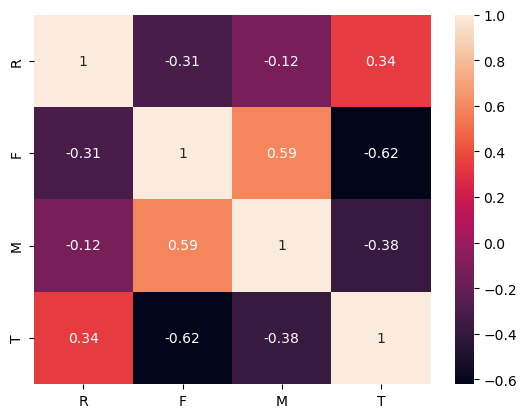

In [41]:
corrMatrix = NonOutliers[["R", "F","M","T"]].corr()
sns.heatmap(corrMatrix, annot = True)

## Normality Checks before Transformation

METHOD 2: K-means ile geriye kalan 1512 outlet için kaç kategoriye bölmek mantıklının cevabı aranacak. 

In [42]:
import statsmodels.api as sm
import pylab as py

QQ Plot

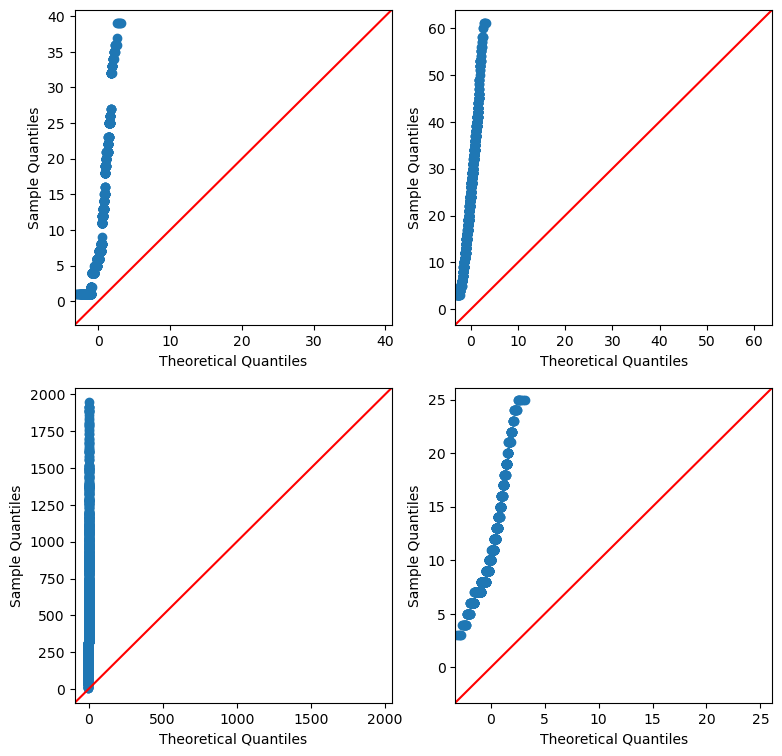

In [43]:
fig, ax = plt.subplots(2,2, figsize = (9,9))
#QQ plot
sm.qqplot(NonOutliers["R"], line ='45', ax = ax[0,0])
sm.qqplot(NonOutliers["F"], line ='45', ax = ax[0,1])
sm.qqplot(NonOutliers["M"], line ='45', ax = ax[1,0])
sm.qqplot(NonOutliers["T"], line ='45', ax = ax[1,1])
py.show()

Probability Plot

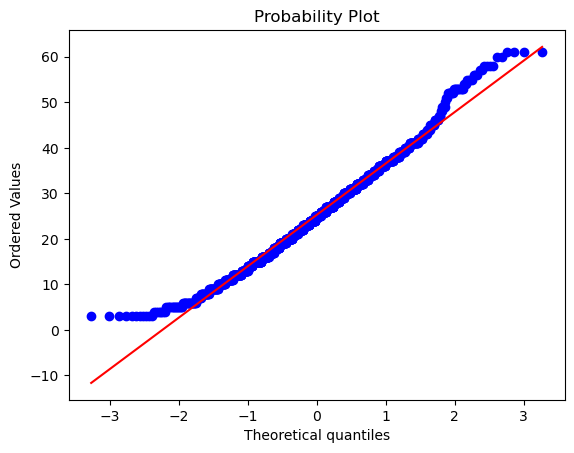

In [44]:
import scipy.stats as stats
#F için prb plot da çizdirdim, normal dist en yakın o 
stats.probplot(NonOutliers["F"], dist ="norm", plot =py)
py.show()

Shapiro-Wilk Test

In [45]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
# normality test
stat, p = shapiro(NonOutliers["T"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.919, p=0.000
Sample does not look Gaussian (reject H0)


## K-means Log Transformation

Before Log Transformation and After Log Transformation graphs were added.

C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='T', ylabel='Density'>

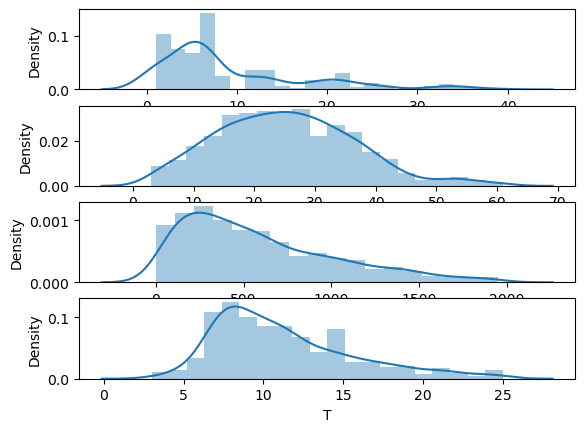

In [46]:
plt.subplot(4, 1, 1); sns.distplot(NonOutliers['R'])
plt.subplot(4, 1, 2); sns.distplot(NonOutliers['F'])
plt.subplot(4, 1, 3); sns.distplot(NonOutliers['M'])
plt.subplot(4, 1, 4); sns.distplot(NonOutliers['T'])

In [47]:
#bu standardize etmeden dönüştürdüğü için sanırım bu silinecek
#NonOutliers["R_log"] = np.log(NonOutliers["R"])
#NonOutliers["F_log"] = np.log(NonOutliers["F"])
#NonOutliers["M_log"] = np.log(NonOutliers["M"])
#NonOutliers["T_log"] = np.log(NonOutliers["T"])

In [48]:
NonOutliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,Rclass,Fclass,Mclass,Tclass,class,score
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers,2,1,1,1,2111,5
5,7030331,5,11,1189.121,20.0,0,0,0,0,NonOutliers,1,1,2,2,1122,6
6,7030428,6,42,326.173,6.0,0,0,0,0,NonOutliers,1,2,1,1,1211,5


Yukarıda verilen ilk grafikten ikinci grafik serisine geçmek için, Outlet Number ve RFMT değerleri yeterli. Alt küme alındı.

In [49]:
#Outlet Number index kısmına alarak, NonOutliers olarak taglediğim liste tekrar yaratıldı. 
KM_NonOutliers = NonOutliers[["Outlet Number", "R", "F", "M", "T"]].set_index("Outlet Number")
KM_NonOutliers.head()

,R,F,M,T
Outlet Number,,,,
7030104,1,22,293.254,12.0
7030259,8,18,222.480,12.0
7030323,12,25,291.102,10.0
7030331,5,11,1189.121,20.0
7030428,6,42,326.173,6.0


In [50]:
from sklearn.preprocessing import StandardScaler
# Unskew the data
datamart_log = np.log(KM_NonOutliers)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)
# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=KM_NonOutliers.index, columns=KM_NonOutliers.columns)

In [51]:
datamart_normalized.describe()

,R,F,M,T
count,1.282000e+03,1.282000e+03,1.282000e+03,1.282000e+03
mean,-2.887868e-17,-6.761795e-16,1.667067e-16,-6.307141e-16
std,1.000390e+00,1.000390e+00,1.000390e+00,1.000390e+00
min,-1.825456e+00,-3.683914e+00,-4.984050e+00,-3.358058e+00
25%,-4.268620e-01,-4.986466e-01,-5.821629e-01,-7.242683e-01
50%,-1.779957e-02,2.095497e-01,1.424190e-01,-1.250680e-01
75%,7.622501e-01,7.193680e-01,7.671943e-01,7.784503e-01
max,1.870609e+00,1.847536e+00,1.670169e+00,2.335419e+00


In [52]:
datamart_normalized.head()

,R,F,M,T
Outlet Number,,,,
7030104,-1.825456,-0.025192,-0.383869,0.364514
7030259,0.272435,-0.393686,-0.683532,0.364514
7030323,0.681497,0.209550,-0.391860,-0.125068
7030331,-0.201739,-1.298026,1.134976,1.736218
7030428,-0.017800,1.162217,-0.268443,-1.496772


C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='T', ylabel='Density'>

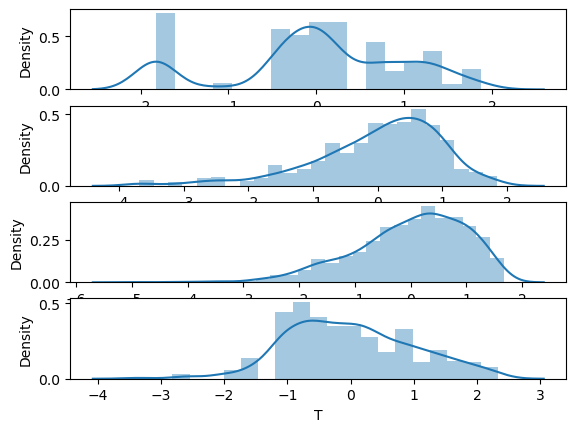

In [53]:
plt.subplot(4, 1, 1); sns.distplot(datamart_normalized['R'])
plt.subplot(4, 1, 2); sns.distplot(datamart_normalized['F'])
plt.subplot(4, 1, 3); sns.distplot(datamart_normalized['M'])
plt.subplot(4, 1, 4); sns.distplot(datamart_normalized['T'])

## K-Means

İlk başta 3 kategori gibi sembolik bir rakamla cluster'lara ayrıldı. Daha sonra Elbow method ile 1-15 arası değerler verilerek optimal sayı ne olurdu diye bakıldı.

In [54]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [55]:
# Create a DataFrame by adding a new cluster label column
KM_NonOutliers_k3 = KM_NonOutliers.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = KM_NonOutliers_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'R': 'mean',
    'F': 'mean',
    'M': 'mean',
    'T': ['mean', 'count']
  }).round(1)

R     F      M     T      
         mean  mean   mean  mean count
Cluster                               
0        13.4  24.3  640.8  11.6   461
1         3.9  34.8  819.6   8.1   485
2        11.4  12.8  173.4  15.3   336

In [56]:
KM_NonOutliers_k3.head()

,R,F,M,T,Cluster
Outlet Number,,,,,
7030104,1,22,293.254,12.0,1
7030259,8,18,222.480,12.0,2
7030323,12,25,291.102,10.0,0
7030331,5,11,1189.121,20.0,0
7030428,6,42,326.173,6.0,1


In [57]:
# Fit KMeans and calculate SSE for each k
sse = {}
for k in range(1, 15):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

C:\Program Files\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


## Elbow Method

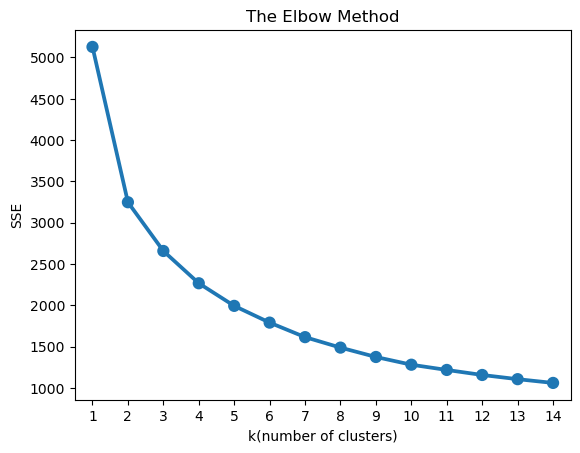

In [58]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

plt.xlabel('k(number of clusters)')
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## Snake Plot

In [59]:
datamart_normalized.head()

,R,F,M,T
Outlet Number,,,,
7030104,-1.825456,-0.025192,-0.383869,0.364514
7030259,0.272435,-0.393686,-0.683532,0.364514
7030323,0.681497,0.209550,-0.391860,-0.125068
7030331,-0.201739,-1.298026,1.134976,1.736218
7030428,-0.017800,1.162217,-0.268443,-1.496772


In [60]:
c_datamart_normalized = datamart_normalized.assign(Cluster=cluster_labels)
c_datamart_normalized.head()

,R,F,M,T,Cluster
Outlet Number,,,,,
7030104,-1.825456,-0.025192,-0.383869,0.364514,1
7030259,0.272435,-0.393686,-0.683532,0.364514,2
7030323,0.681497,0.209550,-0.391860,-0.125068,0
7030331,-0.201739,-1.298026,1.134976,1.736218,0
7030428,-0.017800,1.162217,-0.268443,-1.496772,1


In [61]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(c_datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['Outlet Number', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['R', 'F', 'M', "T"], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

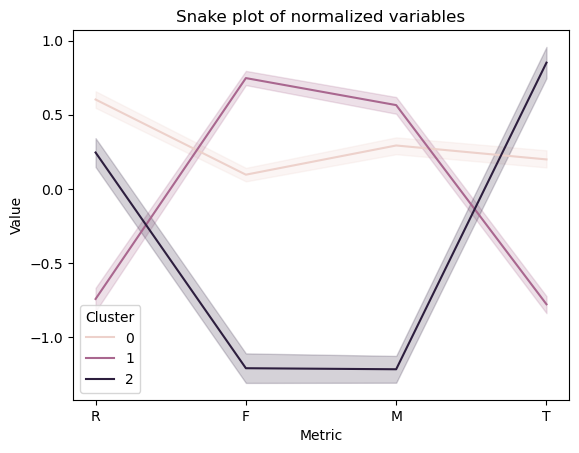

In [62]:
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

## Relative Importance

In [63]:
KM_NonOutliers.head()

,R,F,M,T
Outlet Number,,,,
7030104,1,22,293.254,12.0
7030259,8,18,222.480,12.0
7030323,12,25,291.102,10.0
7030331,5,11,1189.121,20.0
7030428,6,42,326.173,6.0


In [64]:
# Calculate average RFM values for each cluster
cluster_avg = KM_NonOutliers_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = KM_NonOutliers.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

            R     F     M     T
Cluster                        
0        0.44 -0.04  0.09  0.03
1       -0.58  0.38  0.40 -0.28
2        0.23 -0.49 -0.70  0.36


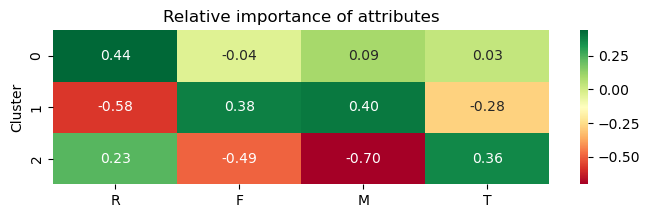

In [65]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

## Enrichment with Outlet Properties

In [66]:
outlet = pd.read_excel(r'C:\Users\tgolgeli\OneDrive - Coca-Cola Icecek A.S\CCI Desktop\OutletProperties.xlsx', index_col = 0)
outlet.head()

,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
Outlet Number,,,,,
7030104,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
7030106,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
7030252,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Superette,SUPERETTE (50-100 M2,TRADITIONAL
7030259,GENERAL HIGH TRAFFIC,SILVER,Full Service Rest,KEBAB / PITA,ON PREMISE
7030323,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Other Eating& Drinking,BAKERY-CAFE,ON PREMISE


In [67]:
RFMT.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers
1,7030106,1,41,12393.778,7.0,0,0,high spend,0,Outliers
2,7030252,4,31,2109.309,10.0,0,0,high spend,0,Outliers
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers


In [68]:
NonOutliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,Rclass,Fclass,Mclass,Tclass,class,score
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers,2,1,1,1,2111,5
5,7030331,5,11,1189.121,20.0,0,0,0,0,NonOutliers,1,1,2,2,1122,6
6,7030428,6,42,326.173,6.0,0,0,0,0,NonOutliers,1,2,1,1,1211,5


In [69]:
c_RFMT = RFMT.copy()
c_RFMT = c_RFMT.merge(outlet, how= "left", on = "Outlet Number")

In [70]:
#ana veriden kontrol edildi, channel: modern
c_RFMT[c_RFMT["Segment"].isna()]

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel


In [71]:
c_RFMT = c_RFMT[c_RFMT["Outlet Number"] != 9615605]
c_RFMT.shape

(1596, 15)

Graphs

<AxesSubplot:>

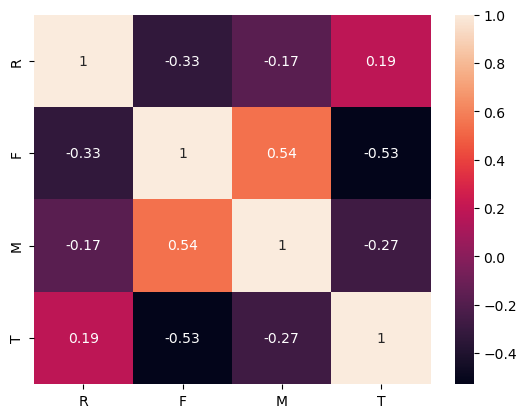

In [72]:
corrMatrix = c_RFMT.drop(labels = "Outlet Number", axis = 1).corr()
sns.heatmap(corrMatrix, annot = True)

## Outliers

Bu kısımda elenen 648 tane değere genel bir bakış sunulacaktır.
Mesela,
Recency düşük olanlar - monetary value min max ve freq min max nedir?
Freq yüksek olanlar yüksek alım mı yapıyorlar yoksa az az mı? min max?
Kimlere şampiyon denilebilir?

In [73]:
Outliers = RFMT[RFMT["Outlier"] == "Outliers"]
Outliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
1,7030106,1,41,12393.778,7.0,0,0,high spend,0,Outliers
2,7030252,4,31,2109.309,10.0,0,0,high spend,0,Outliers
7,7030704,6,10,198.467,29.0,0,0,0,occasional visit,Outliers
8,7030709,1,53,8249.340,6.0,0,0,high spend,0,Outliers
9,7030712,8,26,6208.083,13.0,0,0,high spend,0,Outliers


In [74]:
o_Outliers = Outliers.merge(outlet, on = "Outlet Number", how = "left").drop("Outlier", axis= 1)
o_Outliers.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
0,7030106,1,41,12393.778,7.0,0,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
1,7030252,4,31,2109.309,10.0,0,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Superette,SUPERETTE (50-100 M2,TRADITIONAL
2,7030704,6,10,198.467,29.0,0,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
3,7030709,1,53,8249.340,6.0,0,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE
4,7030712,8,26,6208.083,13.0,0,0,high spend,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Lodging,HOLIDAY RESORT/VILLA,ON PREMISE


## High Spending Outlets (outM) 

Yüksek harcama (high spend) yapan outletlerin (toplamda 143 tane) 1 tanesi hariç hepsi gold segmentinde, Traditional kanal daha çok harcama yapıyor ve Liquor/Beer/Wıne/Soft Drink, Local & Traditional Grocery ve Superette ticari kanallarına mensup bu müşteriler. Ayrıca bu müşterilerin sipariş aralığı ortalaması 7 ama Recency değeri min-max değerleri çok oynamış. Bu değerler incelendiğinde 2 tane  değer hariç diğer değerler 42'den düşük.

In [75]:
o_Outliers[o_Outliers["outM"] == "high spend"].describe()

,Outlet Number,R,F,M,T
count,8.600000e+01,86.000000,86.000000,86.000000,86.000000
mean,8.983470e+06,7.151163,44.895349,3120.513988,7.906977
std,1.017605e+06,8.662994,19.413779,1616.960426,4.659280
min,7.030106e+06,1.000000,5.000000,1955.259000,3.000000
25%,9.148367e+06,1.000000,31.000000,2139.289000,5.000000
50%,9.364340e+06,4.000000,42.000000,2686.802000,7.000000
75%,9.539232e+06,7.000000,60.750000,3377.974000,9.000000
max,1.076394e+07,47.000000,94.000000,12393.778000,29.000000


In [76]:
o_Outliers[o_Outliers["outM"] == "high spend"]["R"].sort_values(ascending = False).head(10)

31     47
313    40
229    32
184    23
287    23
90     23
47     23
303    22
122    20
312    19
Name: R, dtype: int64

In [77]:
o_Outliers[((o_Outliers["R"] == 229) | (o_Outliers["R"] == 194)) & (o_Outliers["outM"] == "high spend")]

#cemil(viktoria) ve safiye sultan dugun salonu

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel


In [78]:
#data[(data["Outlet Number"] == 9526920) | (data["Outlet Number"] == 10755110)]

In [79]:
o_Outliers[o_Outliers["outM"] == "high spend"].groupby(["Segment"])[["outM"]].count()

,outM
Segment,
GOLD,85
SILVER PLUS,1


In [80]:
o_Outliers[o_Outliers["outM"] == "high spend"].groupby(["Management Channel"])[["outM"]].count()

,outM
Management Channel,
ON PREMISE,32
TRADITIONAL,54


In [81]:
o_Outliers[o_Outliers["outM"] == "high spend"].groupby(["Trade Channel", "Sub Trade Channel"])[["outM"]].count()

outM
Trade Channel                   Sub Trade Channel         
Amusement, Recreation & Leisure WEDDING VENUE            2
Bar-Tavern-Licensed Est         BAR/PUB/TAVERN           3
Full Service Rest               DINER/CASUAL DINING/     3
                                FINE-DINING RESTAURA     6
                                KEBAB / PITA - LUXUR     1
Liquor/Beer/Wıne/Soft Drink     DRY FRUIT-(ALCOHOL)     12
Local & Traditional Grocery     GROCERY/MOMP-WALK IN    19
Lodging                         GOVERMENTAL STAY         1
                                HOLIDAY RESORT/VILLA     4
Other Eating& Drinking          TEA GARDEN               1
QSR                             MODERN FAST FOOD RES     4
                                TRADITIONAL FAST FOO     6
Retail Speciality Service       OTHER RETAIL SPECIAL     2
                                SUB-DEALER               1
Specialty Food Store            BAKERY/PASTRY            1
                                DELICATESSEN             1
                                DRY FRUIT-NONALCOHOL     1
Street Vendor                   KIOSK/FOOD/CANTEEN       1
Superette                       SUPERETTE (50-100 M2    17

## Frequent Buyers (outF)

Bu kategoride toplamda 31 değer bulunmaktadır. Kesilen fatura miktarı 95-167 arasında değişmektedir. Recency: 1-6, Time Interval: 3-7, Monetary (UC Volume) miktarı en az 1373 ve ortalamada 4235'dir. Bu müşteriler -UC miktarı da gözetilerek- 
şampiyon müşteri olmaya aday olabilirler.

In [82]:
freq = o_Outliers[o_Outliers["outF"] == "freq buyers"]
freq.describe()

,Outlet Number,R,F,M,T
count,4.000000e+01,40.000000,40.000000,40.000000,40.000000
mean,8.866259e+06,4.675000,72.350000,2250.441375,4.700000
std,1.030251e+06,5.735126,9.773197,1281.218011,1.522481
min,7.035780e+06,1.000000,62.000000,905.864000,3.000000
25%,9.022227e+06,1.000000,65.000000,1461.896750,4.000000
50%,9.286674e+06,4.000000,71.000000,1876.725000,4.000000
75%,9.494338e+06,5.250000,76.000000,2524.451250,5.250000
max,1.067573e+07,32.000000,107.000000,7649.702000,9.000000


In [83]:
freq.groupby(["Segment", "Management Channel"])[["Outlet Number"]].count()

Outlet Number
Segment     Management Channel               
GOLD        ON PREMISE                     16
            TRADITIONAL                    18
SILVER PLUS TRADITIONAL                     6

## Low Recency (outR)

Toplamda 368 tane müşterinin alım sıklıkları düşük. 61 - 353 gibi geniş bir aralıkta değişiyor.

In [84]:
l_rec = o_Outliers[o_Outliers["outR"] == "low recency"]
l_rec.describe()

,Outlet Number,R,F,M,T
count,1.150000e+02,115.000000,115.000000,115.000000,115.000000
mean,9.102153e+06,94.356522,10.173913,307.526122,20.382609
std,1.026792e+06,61.352332,6.140548,573.095299,11.020382
min,7.031622e+06,40.000000,3.000000,12.256000,4.000000
25%,9.092792e+06,49.000000,5.000000,59.390000,13.000000
50%,9.453235e+06,64.000000,8.000000,113.435000,17.000000
75%,9.630092e+06,130.500000,13.500000,298.795000,24.000000
max,1.076394e+07,272.000000,26.000000,3849.275000,55.000000


In [85]:
l_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 5 to 313
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Outlet Number       115 non-null    int64  
 1   R                   115 non-null    int64  
 2   F                   115 non-null    int64  
 3   M                   115 non-null    float64
 4   T                   115 non-null    float64
 5   outR                115 non-null    object 
 6   outF                115 non-null    object 
 7   outM                115 non-null    object 
 8   outT                115 non-null    object 
 9   Cluster             115 non-null    object 
 10  Segment             115 non-null    object 
 11  Trade Channel       115 non-null    object 
 12  Sub Trade Channel   115 non-null    object 
 13  Management Channel  115 non-null    object 
dtypes: float64(2), int64(3), object(9)
memory usage: 13.5+ KB


In [86]:
def Rinterval(df):    
    if df['R'] < 100:
        return '<100'
    elif df['R'] < 200:
        return '100-199'
    elif df['R'] < 300:
        return '200-299'
    else:
        return '>= 300'
    
#l_rec['RInterval'] = l_rec.apply(Rinterval, axis = 1)
l_rec = l_rec.assign(RInterval=l_rec.apply(Rinterval, axis=1))

In [87]:
l_rec

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel,RInterval
5,7031622,46,12,169.752,19.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Liquor/Beer/Wıne/Soft Drink,DRY FRUIT-(ALCOHOL),TRADITIONAL,<100
7,7032296,46,15,1285.563,20.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL,<100
8,7033340,48,18,498.591,13.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL,<100
10,7033936,49,13,116.144,16.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER,QSR,TRADITIONAL FAST FOO,ON PREMISE,<100
11,7034054,48,3,217.156,55.0,low recency,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL,<100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,10755420,55,5,86.425,7.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Full Service Rest,TRADITIONAL RESTAURA,ON PREMISE,<100
306,10756680,62,7,191.754,9.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER,Other Eating& Drinking,COFFEE HOUSE-SPECIAL,ON PREMISE,<100
308,10759855,43,5,85.751,15.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER,QSR,TRADITIONAL FAST FOO,ON PREMISE,<100
311,10761965,57,6,60.472,7.0,low recency,0,0,0,GENERAL RESIDENTIAL AREA LOCATED,SILVER,"Amusement, Recreation & Leisure","AMUSEMENT, RECRATION",ON PREMISE,<100


In [88]:
l_rec.groupby("RInterval")["Outlet Number"].count()

RInterval
100-199    25
200-299    12
<100       78
Name: Outlet Number, dtype: int64

Which customers are valuable out of them?

17 tane outlet yıl boyunca 39 ve üzeri fatura kestirmiş, 14 outletin ise UC volume'u 1500 üzerindedir. bu outletlerin Recency değeri attırılmaya çalışılabilir.

In [89]:
l_rec["F"].sort_values(ascending = False).head(20)

182    26
26     25
300    25
22     25
36     24
56     22
92     22
50     22
66     22
200    21
13     21
247    20
190    20
281    20
17     20
54     19
165    19
8      18
68     17
99     17
Name: F, dtype: int64

In [90]:
must = l_rec[l_rec["F"] > 39]["Outlet Number"]
data[data["Outlet Number"].isin(must)]["Outlet Name"].unique()

array([], dtype=object)

In [91]:
l_rec["M"].sort_values(ascending = False).head(15)

31     3849.275
313    3745.401
36     1760.464
68     1595.007
247    1288.245
7      1285.563
123    1284.626
284    1188.960
26     1007.918
200     780.662
281     735.079
105     718.369
232     653.870
182     578.262
152     551.580
Name: M, dtype: float64

In [92]:
must = l_rec[l_rec["M"] > 1500]["Outlet Number"]
data[data["Outlet Number"].isin(must)]["Outlet Name"].unique()

array(['MERI DAY WAFFLE - MERYEM GUNAY',
       'POLAT TERMAL HOTEL - HP.MUSAVIRLIK DAN.OTEL A.S.',
       'YESILCAM BAHCE',
       'MARLA RESTAURANT - CANKA GID.TUR.MAD.SAN TIC LTD'], dtype=object)

## Long Time Intervals (outT)

177 tane değer için sipariş sıklığı 28 gün ve üzeri. UC Volume 1500 üzerinde olan 1, 1000 ve üzerinde olan 6 tane outlet bulunmakta. Recency değerleri de çok çeşitli (1-289 arası). Recency <= 10, 46 outlet ve Recency < 50, 122 tane outlet var. Monetary value bazlı bir değerlendirme yapılabilir.

In [93]:
longT = o_Outliers[o_Outliers["outT"] == "occasional visit"]
longT.describe()

,Outlet Number,R,F,M,T
count,1.220000e+02,122.000000,122.000000,122.000000,122.000000
mean,9.300642e+06,29.278689,6.819672,181.483500,41.213115
std,7.495181e+05,32.429775,2.675312,307.572597,19.361387
min,7.030704e+06,1.000000,3.000000,9.806000,26.000000
25%,9.245954e+06,11.250000,5.000000,47.165500,29.000000
50%,9.517174e+06,20.000000,6.000000,89.713000,34.000000
75%,9.651372e+06,36.000000,9.000000,193.127750,46.000000
max,1.076069e+07,190.000000,14.000000,2789.456000,160.000000


In [94]:
longT[longT["M"] >= 1500]

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
122,9278725,20,14,2789.456,29.0,0,0,high spend,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL


In [95]:
longT[longT["M"] >= 1000]

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Cluster,Segment,Trade Channel,Sub Trade Channel,Management Channel
18,7035153,7,9,1096.822,31.0,0,0,0,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Retail Speciality Service,OTHER RETAIL SPECIAL,TRADITIONAL
122,9278725,20,14,2789.456,29.0,0,0,high spend,occasional visit,GENERAL RESIDENTIAL AREA LOCATED,GOLD,Local & Traditional Grocery,GROCERY/MOMP-WALK IN,TRADITIONAL


In [96]:
longT[longT["R"] <= 10].shape, longT[longT["R"] < 50].shape

((27, 14), (105, 14))

## Summary Table for Outliers

In [97]:
o_Outliers.groupby(["outR", "outF", "outM", "outT"])[["Outlet Number"]].count()

Outlet Number
outR        outF        outM       outT                           
0           0           0          occasional visit             95
                        high spend 0                            63
                                   occasional visit              1
            freq buyers 0          0                            20
                        high spend 0                            20
low recency 0           0          0                            87
                                   occasional visit             26
                        high spend 0                             2

In [98]:
o_Outliers.groupby(["Segment", "outR", "outF", "outM", "outT"])[["Outlet Number"]].count()

Outlet Number
Segment     outR        outF        outM       outT                           
BRONZE      0           0           0          occasional visit             12
            low recency 0           0          0                            15
                                               occasional visit              8
GOLD        0           0           0          occasional visit             12
                                    high spend 0                            62
                                               occasional visit              1
                        freq buyers 0          0                            14
                                    high spend 0                            20
            low recency 0           0          0                            15
                                               occasional visit              1
                                    high spend 0                             2
SILVER      0           0           0          occasional visit             68
            low recency 0           0          0                            49
                                               occasional visit             17
SILVER PLUS 0           0           0          occasional visit              3
                                    high spend 0                             1
                        freq buyers 0          0                             6
            low recency 0           0          0                             8

## RFMT without Outlier Elimination

Outlier elenmeden segmentlere ayrılsaydı ka. grup oluşurdu?

In [99]:
RFMT.head()

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers
1,7030106,1,41,12393.778,7.0,0,0,high spend,0,Outliers
2,7030252,4,31,2109.309,10.0,0,0,high spend,0,Outliers
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers


In [100]:
RFMT.shape

(1596, 10)

In [101]:
nRFMT = RFMT[["Outlet Number", "R", "F", "M", "T"]].set_index("Outlet Number")
nRFMT

,R,F,M,T
Outlet Number,,,,
7030104,1,22,293.254,12.0
7030106,1,41,12393.778,7.0
7030252,4,31,2109.309,10.0
7030259,8,18,222.480,12.0
7030323,12,25,291.102,10.0
...,...,...,...,...
10774264,1,3,165.914,11.0
10775542,21,3,50.921,11.0
10776537,6,5,129.102,7.0


In [102]:
from sklearn.preprocessing import StandardScaler
# Unskew the data
ndatamart_log = np.log(nRFMT)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
ndatamart_normalized = scaler.transform(ndatamart_log)
# Create a pandas DataFrame
ndatamart_normalized = pd.DataFrame(data=ndatamart_normalized, index=nRFMT.index, columns=nRFMT.columns)

In [103]:
ndatamart_normalized.describe()

,R,F,M,T
count,1596.000000,1596.000000,1596.000000,1596.000000
mean,0.197229,-0.174690,-0.057668,0.226778
std,1.194808,1.261635,1.235598,1.438100
min,-1.825456,-3.683914,-4.984050,-3.358058
25%,-0.426862,-0.855177,-0.796506,-0.724268
50%,0.137719,0.056435,0.084408,0.130865
75%,1.090560,0.719368,0.833887,0.963715
max,3.830082,2.879460,3.678062,7.320077


C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Program Files\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='T', ylabel='Density'>

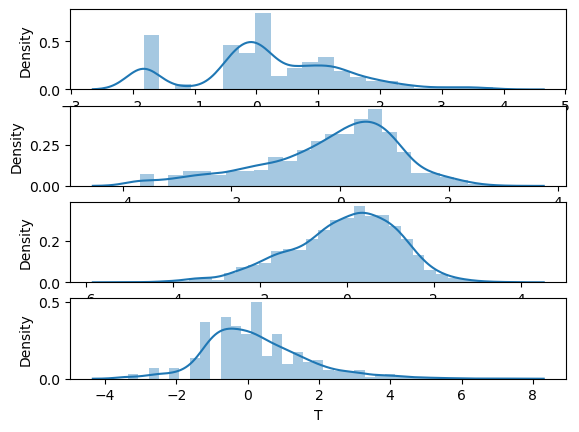

In [104]:
plt.subplot(4, 1, 1); sns.distplot(ndatamart_normalized['R'])
plt.subplot(4, 1, 2); sns.distplot(ndatamart_normalized['F'])
plt.subplot(4, 1, 3); sns.distplot(ndatamart_normalized['M'])
plt.subplot(4, 1, 4); sns.distplot(ndatamart_normalized['T'])

In [105]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(ndatamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

In [106]:
# Create a DataFrame by adding a new cluster label column
nRFMT_k3 = nRFMT.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = nRFMT_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'R': 'mean',
    'F': 'mean',
    'M': 'mean',
    'T': ['mean', 'count']
  }).round(1)

R     F       M     T      
         mean  mean    mean  mean count
Cluster                                
0         4.8  39.2  1229.9   7.6   548
1        40.1   8.2   139.3  26.6   319
2        13.1  21.2   512.8  12.2   729

In [107]:
# Fit KMeans and calculate SSE for each k
sse = {}
for k in range(1, 15):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(ndatamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

C:\Program Files\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


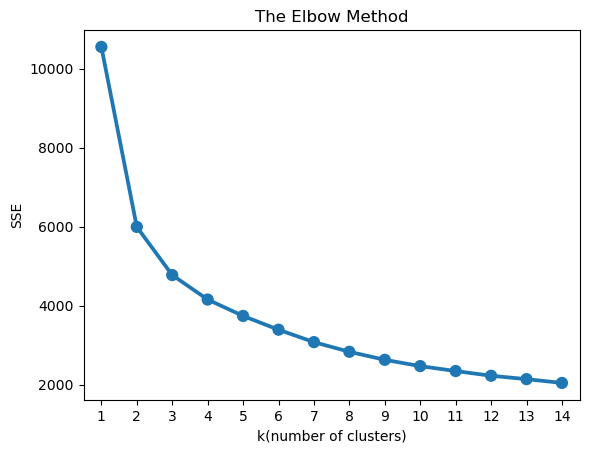

In [108]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

plt.xlabel('k(number of clusters)')
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [109]:
cn_datamart_normalized = ndatamart_normalized.assign(Cluster=cluster_labels)
cn_datamart_normalized.head()

,R,F,M,T,Cluster
Outlet Number,,,,,
7030104,-1.825456,-0.025192,-0.383869,0.364514,2
7030106,-1.825456,1.117966,3.678062,-1.082836,0
7030252,-0.426862,0.604561,1.756807,-0.125068,0
7030259,0.272435,-0.393686,-0.683532,0.364514,2
7030323,0.681497,0.209550,-0.391860,-0.125068,2


In [110]:
# Melt the normalized dataset and reset the index
ndatamart_melt = pd.melt(cn_datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['Outlet Number', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['R', 'F', 'M', "T"], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

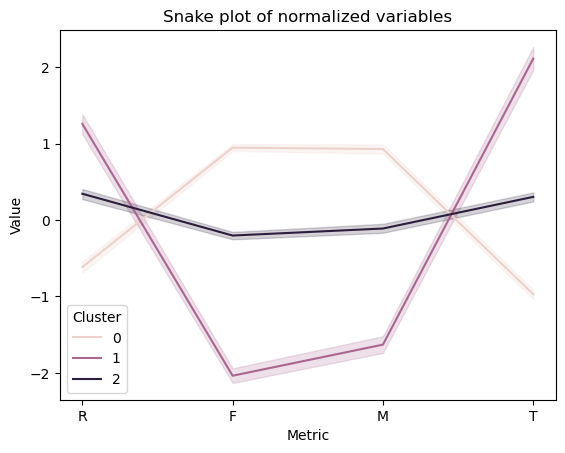

In [111]:
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=ndatamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

In [112]:
nRFMT_k3.head()

,R,F,M,T,Cluster
Outlet Number,,,,,
7030104,1,22,293.254,12.0,2
7030106,1,41,12393.778,7.0,0
7030252,4,31,2109.309,10.0,0
7030259,8,18,222.480,12.0,2
7030323,12,25,291.102,10.0,2


In [113]:
# Calculate average RFM values for each cluster
cluster_avg = nRFMT_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = nRFMT.mean()

# Calculate relative importance of cluster's attribute value compared to population
nrelative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(nrelative_imp.round(2))

            R     F     M     T
Cluster                        
0       -0.69  0.58  0.80 -0.44
1        1.57 -0.67 -0.80  0.97
2       -0.16 -0.14 -0.25 -0.10


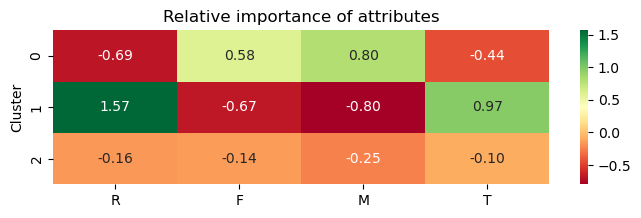

In [114]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=nrelative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

## Data Manipulation before Comparison

In [115]:
RFMT

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers
1,7030106,1,41,12393.778,7.0,0,0,high spend,0,Outliers
2,7030252,4,31,2109.309,10.0,0,0,high spend,0,Outliers
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers
...,...,...,...,...,...,...,...,...,...,...
1651,10774264,1,3,165.914,11.0,0,0,0,0,NonOutliers
1653,10775542,21,3,50.921,11.0,0,0,0,0,NonOutliers
1656,10776537,6,5,129.102,7.0,0,0,0,0,NonOutliers
1658,10776992,1,3,22.041,10.0,0,0,0,0,NonOutliers


In [116]:
NonOutliers

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,Rclass,Fclass,Mclass,Tclass,class,score
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers,1,1,1,2,1112,5
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers,2,1,1,1,2111,5
5,7030331,5,11,1189.121,20.0,0,0,0,0,NonOutliers,1,1,2,2,1122,6
6,7030428,6,42,326.173,6.0,0,0,0,0,NonOutliers,1,2,1,1,1211,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,10774264,1,3,165.914,11.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
1653,10775542,21,3,50.921,11.0,0,0,0,0,NonOutliers,2,1,1,1,2111,5
1656,10776537,6,5,129.102,7.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4
1658,10776992,1,3,22.041,10.0,0,0,0,0,NonOutliers,1,1,1,1,1111,4


In [117]:
py_denizli = RFMT.merge(NonOutliers[["Outlet Number", "class", "score"]], on = "Outlet Number", how = "left")
py_denizli

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,class,score
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers,1112,5.0
1,7030106,1,41,12393.778,7.0,0,0,high spend,0,Outliers,NaN,NaN
2,7030252,4,31,2109.309,10.0,0,0,high spend,0,Outliers,NaN,NaN
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers,1112,5.0
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers,2111,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1591,10774264,1,3,165.914,11.0,0,0,0,0,NonOutliers,1111,4.0
1592,10775542,21,3,50.921,11.0,0,0,0,0,NonOutliers,2111,5.0
1593,10776537,6,5,129.102,7.0,0,0,0,0,NonOutliers,1111,4.0
1594,10776992,1,3,22.041,10.0,0,0,0,0,NonOutliers,1111,4.0


In [118]:
curr_denizli = pd.read_excel(r'C:\Users\tgolgeli\OneDrive - Coca-Cola Icecek A.S\CCI Desktop\2023L1Y_denizliclasses.xlsx', index_col = 0)
curr_denizli

,Outlet Number,R,F,M,T,outR,outF,outM,outT,Outlier,class,score
0,7030104,44,19,293.419,18,0,0,0,0,NonOutliers,2112.0,6.0
1,7030106,6,54,20765.917,7,0,0,high spend,0,Outliers,NaN,NaN
2,7030252,20,54,2601.616,8,0,0,0,0,NonOutliers,2221.0,7.0
3,7030259,2,32,362.613,11,0,0,0,0,NonOutliers,1111.0,4.0
4,7030323,83,9,198.252,37,low recency,0,0,occasional visit,Outliers,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,10851942,5,3,100.020,10,0,0,0,0,NonOutliers,1111.0,4.0
2156,10852129,8,3,262.307,10,0,0,0,0,NonOutliers,1111.0,4.0
2157,10852804,2,4,47.657,6,0,0,0,0,NonOutliers,1111.0,4.0
2158,10853491,6,4,33.306,4,0,0,0,0,NonOutliers,1111.0,4.0


In [119]:
combined = py_denizli.merge(curr_denizli, on = "Outlet Number", how = "left", suffixes = ["_py", "_curr"])
combined

,Outlet Number,R_py,F_py,M_py,T_py,outR_py,outF_py,outM_py,outT_py,Outlier_py,...,F_curr,M_curr,T_curr,outR_curr,outF_curr,outM_curr,outT_curr,Outlier_curr,class_curr,score_curr
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers,...,19.0,293.419,18.0,0,0,0,0,NonOutliers,2112.0,6.0
1,7030106,1,41,12393.778,7.0,0,0,high spend,0,Outliers,...,54.0,20765.917,7.0,0,0,high spend,0,Outliers,NaN,NaN
2,7030252,4,31,2109.309,10.0,0,0,high spend,0,Outliers,...,54.0,2601.616,8.0,0,0,0,0,NonOutliers,2221.0,7.0
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers,...,32.0,362.613,11.0,0,0,0,0,NonOutliers,1111.0,4.0
4,7030323,12,25,291.102,10.0,0,0,0,0,NonOutliers,...,9.0,198.252,37.0,low recency,0,0,occasional visit,Outliers,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,10774264,1,3,165.914,11.0,0,0,0,0,NonOutliers,...,64.0,1756.854,6.0,0,0,0,0,NonOutliers,1221.0,6.0
1592,10775542,21,3,50.921,11.0,0,0,0,0,NonOutliers,...,22.0,363.670,18.0,0,0,0,0,NonOutliers,1112.0,5.0
1593,10776537,6,5,129.102,7.0,0,0,0,0,NonOutliers,...,36.0,1040.661,10.0,0,0,0,0,NonOutliers,1221.0,6.0
1594,10776992,1,3,22.041,10.0,0,0,0,0,NonOutliers,...,21.0,214.513,12.0,low recency,0,0,0,Outliers,NaN,NaN


In [120]:
combined.columns

Index(['Outlet Number', 'R_py', 'F_py', 'M_py', 'T_py', 'outR_py', 'outF_py',
       'outM_py', 'outT_py', 'Outlier_py', 'class_py', 'score_py', 'R_curr',
       'F_curr', 'M_curr', 'T_curr', 'outR_curr', 'outF_curr', 'outM_curr',
       'outT_curr', 'Outlier_curr', 'class_curr', 'score_curr'],
      dtype='object')

1596 tane ortak olan outlet için 21-22 ve 22-23 yılları aynı aralıkların değerleri incelendiğinde, ortalama Recency değeri PY değeri daha iyi, kesilen fatura sayısı artmış. Sipariş verilen ortalama miktar neredeyse 2 katına çıkmış. Ortalama sipariş verme miktarları benzer. 

In [121]:
combined.describe()

,Outlet Number,R_py,F_py,M_py,T_py,score_py,R_curr,F_curr,M_curr,T_curr,class_curr,score_curr
count,1.596000e+03,1596.000000,1596.000000,1596.000000,1596.000000,1282.000000,1551.000000,1551.000000,1551.000000,1551.000000,1060.000000,1060.000000
mean,9.158335e+06,15.639098,24.766291,684.354411,13.493108,5.574883,42.638298,36.250806,1153.042403,12.772405,1492.811321,5.824528
std,1.049463e+06,28.617860,14.595482,816.926030,10.572423,0.843449,80.361346,21.366984,1432.312108,9.778405,452.438021,0.681166
min,7.030104e+06,1.000000,3.000000,4.225000,3.000000,4.000000,1.000000,3.000000,7.605000,3.000000,1111.000000,4.000000
25%,9.119078e+06,4.000000,14.000000,200.478750,8.000000,5.000000,5.000000,20.000000,340.136000,7.000000,1211.000000,5.000000
50%,9.467772e+06,7.000000,23.000000,451.535500,11.000000,6.000000,8.000000,36.000000,794.587000,9.000000,1221.000000,6.000000
75%,9.627733e+06,18.000000,33.000000,900.953750,15.000000,6.000000,27.000000,49.000000,1455.677000,14.000000,2112.000000,6.000000
max,1.077772e+07,272.000000,107.000000,12393.778000,160.000000,8.000000,353.000000,167.000000,20765.917000,104.000000,2222.000000,8.000000


## Interyears Comparisons

Aşağıdaki tablolarda CCINext üzerinden alım yapan ortak outletler karşılaştırıldığında, outlier olarak sınıflandırılanlar arasındaki geçişleri betimlemektedir. 1551 tane outlet universe'ümüzü oluşturmaktadır.
Recency: 237 outlet low recency'e geçerken, 73 tanesi recency değerini geliştirerek normal sınırlara gelmiştir.
Frequency: 16 outlet fatura kesim miktarını arttırmış , 26'sı azaltmıştır.
Monetary: 66 tanesi UC değerini arttırarak normal sipariş aralığının üstüne çıkmıştır. 19'u ise high spend'den normale geçiş yapmıştır.
Time Interval: 77 tanesi CCINext üzerinden sipariş aralığını düşürmüştür, 72 tanesi ise daha sık alım yapmaya başlamıştır.

In [122]:
R = combined[["Outlet Number", "outR_py", "outR_curr"]].dropna()
R

,Outlet Number,outR_py,outR_curr
0,7030104,0,0
1,7030106,0,0
2,7030252,0,0
3,7030259,0,0
4,7030323,0,low recency
...,...,...,...
1591,10774264,0,0
1592,10775542,0,0
1593,10776537,0,0
1594,10776992,0,low recency


In [123]:
R["comp"] = np.where(R["outR_py"] != R["outR_curr"], "diff", "same")
pd.DataFrame(R[R["comp"] == "diff"].groupby(["outR_py", "outR_curr"])["comp"].count())

,,comp
outR_py,outR_curr,
0,low recency,237
low recency,0,73


In [124]:
F = combined[["Outlet Number", "outF_py", "outF_curr"]].dropna()
F["comp"] = np.where(F["outF_py"] != F["outF_curr"], "diff", "same")
pd.DataFrame(F[F["comp"] == "diff"].groupby(["outF_py", "outF_curr"])["comp"].count())

,,comp
outF_py,outF_curr,
0,freq buyers,16
freq buyers,0,26


In [125]:
M = combined[["Outlet Number", "outM_py", "outM_curr"]].dropna()
M["comp"] = np.where(M["outM_py"] != M["outM_curr"], "diff", "same")
pd.DataFrame(M[M["comp"] == "diff"].groupby(["outM_py", "outM_curr"])["comp"].count())

,,comp
outM_py,outM_curr,
0,high spend,66
high spend,0,19


In [126]:
T = combined[["Outlet Number", "outT_py", "outT_curr"]].dropna()
T["comp"] = np.where(T["outT_py"] != T["outT_curr"], "diff", "same")
pd.DataFrame(T[T["comp"] == "diff"].groupby(["outT_py", "outT_curr"])["comp"].count())

,,comp
outT_py,outT_curr,
0,occasional visit,77
occasional visit,0,72


311 tane outlet Nonoutliers statüsünden Outliers statüsüne geçmiştir. Outliers olan 113 değer ise NonOutliers olmuştur.

In [127]:
pd.DataFrame(combined.groupby(["Outlier_py", "Outlier_curr"])["Outlet Number"].count())

Outlet Number
Outlier_py  Outlier_curr               
NonOutliers NonOutliers             947
            Outliers                311
Outliers    NonOutliers             113
            Outliers                180

In [128]:
'class_py', 'score_py', 'class_curr', 'score_curr'

('class_py', 'score_py', 'class_curr', 'score_curr')

In [129]:
pd.DataFrame(combined.groupby(['score_py', 'score_curr'])["Outlet Number"].count())

Outlet Number
score_py score_curr               
4.0      4.0                     2
         5.0                    26
         6.0                    56
         7.0                     7
5.0      4.0                     6
         5.0                   153
         6.0                   163
         7.0                    26
         8.0                     1
6.0      4.0                     4
         5.0                    73
         6.0                   254
         7.0                    64
         8.0                     1
7.0      5.0                    11
         6.0                    60
         7.0                    25
         8.0                     2
8.0      5.0                     1
         6.0                     7
         7.0                     4
         8.0                     1

In [130]:
combined["inc/dec"] = combined["score_curr"] - combined["score_py"]
class_comb = combined
class_comb.dropna(inplace = True)
class_comb

,Outlet Number,R_py,F_py,M_py,T_py,outR_py,outF_py,outM_py,outT_py,Outlier_py,...,M_curr,T_curr,outR_curr,outF_curr,outM_curr,outT_curr,Outlier_curr,class_curr,score_curr,inc/dec
0,7030104,1,22,293.254,12.0,0,0,0,0,NonOutliers,...,293.419,18.0,0,0,0,0,NonOutliers,2112.0,6.0,1.0
3,7030259,8,18,222.480,12.0,0,0,0,0,NonOutliers,...,362.613,11.0,0,0,0,0,NonOutliers,1111.0,4.0,-1.0
6,7030428,6,42,326.173,6.0,0,0,0,0,NonOutliers,...,505.709,5.0,0,0,0,0,NonOutliers,1211.0,5.0,0.0
10,7030778,25,12,156.772,22.0,0,0,0,0,NonOutliers,...,671.756,13.0,0,0,0,0,NonOutliers,1112.0,5.0,-1.0
11,7030791,7,46,567.007,6.0,0,0,0,0,NonOutliers,...,1210.099,7.0,0,0,0,0,NonOutliers,1221.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590,10773921,1,8,94.055,7.0,0,0,0,0,NonOutliers,...,1376.438,7.0,0,0,0,0,NonOutliers,1221.0,6.0,2.0
1591,10774264,1,3,165.914,11.0,0,0,0,0,NonOutliers,...,1756.854,6.0,0,0,0,0,NonOutliers,1221.0,6.0,2.0
1592,10775542,21,3,50.921,11.0,0,0,0,0,NonOutliers,...,363.670,18.0,0,0,0,0,NonOutliers,1112.0,5.0,0.0
1593,10776537,6,5,129.102,7.0,0,0,0,0,NonOutliers,...,1040.661,10.0,0,0,0,0,NonOutliers,1221.0,6.0,2.0


In [131]:
change_in_score = pd.DataFrame(class_comb.groupby("inc/dec")["Outlet Number"].count())
change_in_score

,Outlet Number
inc/dec,
-3.0,1
-2.0,22
-1.0,143
0.0,435
1.0,255
2.0,83
3.0,8


RFMT scorelamasında  endex değerlerinin toplamı, 947 outlet içerisinden 435 tane outlette aynı kalmıştır.166 tanesinin score'u düşmüştür. 346'sinde ise artmıştır. (Hesaplama: current year score - previous year score)

In [132]:
class_ch = combined[["Outlet Number", "class_py", "class_curr"]].dropna()
class_ch

,Outlet Number,class_py,class_curr
0,7030104,1112,2112.0
3,7030259,1112,1111.0
6,7030428,1211,1211.0
10,7030778,2112,1112.0
11,7030791,1211,1221.0
...,...,...,...
1590,10773921,1111,1221.0
1591,10774264,1111,1221.0
1592,10775542,2111,1112.0
1593,10776537,1111,1221.0


In [133]:
class_ch["class_py"] = class_ch["class_py"].astype("float")
class_ch["comp"] = np.where(class_ch["class_py"] != class_ch["class_curr"], "diff", "same")

In [134]:
pd.DataFrame(class_ch[class_ch["comp"] == "diff"].groupby(["class_py", "class_curr"])["comp"].count())

comp
class_py class_curr      
1111.0   1112.0         5
         1122.0         3
         1211.0        19
         1212.0         1
         1221.0        35
...                   ...
2222.0   1221.0         4
         2112.0         1
         2121.0         1
         2122.0         1
         2221.0         3

[118 rows x 1 columns]

In [135]:
class_ch.query('comp == "same"')

,Outlet Number,class_py,class_curr,comp
6,7030428,1211.0,1211.0,same
13,7030923,1211.0,1211.0,same
17,7031257,1221.0,1221.0,same
22,7031525,1221.0,1221.0,same
23,7031528,2111.0,2111.0,same
...,...,...,...,...
1479,10738705,1221.0,1221.0,same
1502,10755322,1112.0,1112.0,same
1531,10760832,1112.0,1112.0,same
1570,10768898,2112.0,2112.0,same


In [136]:
class_diff = class_ch.query('comp == "diff"')
class_diff

,Outlet Number,class_py,class_curr,comp
0,7030104,1112.0,2112.0,diff
3,7030259,1112.0,1111.0,diff
10,7030778,2112.0,1112.0,diff
11,7030791,1211.0,1221.0,diff
12,7030890,1112.0,1121.0,diff
...,...,...,...,...
1590,10773921,1111.0,1221.0,diff
1591,10774264,1111.0,1221.0,diff
1592,10775542,2111.0,1112.0,diff
1593,10776537,1111.0,1221.0,diff


In [137]:
class_diff.groupby(["class_py", "class_curr"], as_index = False)["Outlet Number"].count().sort_values(by = "Outlet Number", ascending = False)

,class_py,class_curr,Outlet Number
36,1211.0,1221.0,37
55,1221.0,2221.0,36
4,1111.0,1221.0,35
108,2221.0,1221.0,34
73,2112.0,1112.0,32
...,...,...,...
23,1121.0,2112.0,1
91,2122.0,1222.0,1
46,1221.0,1111.0,1
93,2122.0,2121.0,1
